In [1]:
#Importing necessary libraries

#importing data handling libraries
import pandas as pd
import numpy as np
from collections import OrderedDict
from pandasql import sqldf


#importing data visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

#importing statistical libraries
import scipy.stats as sc
from statsmodels.stats.outliers_influence import variance_inflation_factor

#importing data preprocessing libraries
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA


#importing machine learning libraries
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
import xgboost
from xgboost import XGBRegressor


#importing validation and model selection libraries
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, learning_curve
from sklearn.metrics import r2_score, mean_squared_error


#importing libraries to handle warnings
import warnings
warnings.filterwarnings('ignore')

In [42]:
df_personal = pd.read_excel('raman/Medibuddy insurance data personal details copy.xlsx')
df_insurance = pd.read_csv('raman/Medibuddy Insurance Data Price.csv')

In [43]:
df_insurance.head(10)

,Policy no.,age,sex,bmi,charges in INR
0,PLC156898,19,female,27.900,16884.92400
1,PLC156907,18,male,33.770,1725.55230
2,PLC156916,28,male,33.000,4449.46200
3,PLC156925,33,male,22.705,21984.47061
4,PLC156934,32,male,28.880,3866.85520
5,PLC156943,31,female,25.740,3756.62160
6,PLC156952,46,female,33.440,8240.58960
7,PLC156961,37,female,27.740,7281.50560
8,PLC156970,37,male,29.830,6406.41070
9,PLC156979,60,female,25.840,28923.13692


In [44]:
df_personal[:10]

,Policy no.,children,smoker,region
0,PLC157006,0,no,southwest
1,PLC157033,1,no,southwest
2,PLC157060,0,no,southwest
3,PLC157087,1,no,southwest
4,PLC157186,5,no,southwest
5,PLC157231,0,no,southwest
6,PLC157303,0,no,southwest
7,PLC157483,0,no,southwest
8,PLC157492,2,no,southwest
9,PLC157546,3,no,southwest


In [45]:
df_insurance.rename(columns = {'Policy no.':'policy_number'}, inplace = True)
df_personal.rename(columns = {'Policy no.':'policy_number'}, inplace = True)

In [46]:
#Label encoding
le = LabelEncoder()
df_insurance['sex'] = le.fit_transform(df_insurance['sex'])
df_personal['region'] = le.fit_transform(df_personal['region'])
df_personal['smoker'] = le.fit_transform(df_personal['smoker'])

In [47]:
df_personal.head()

,policy_number,children,smoker,region
0,PLC157006,0,0,3
1,PLC157033,1,0,3
2,PLC157060,0,0,3
3,PLC157087,1,0,3
4,PLC157186,5,0,3


In [48]:
mysql = lambda q: sqldf(q, globals())

In [49]:
query = '''select * from df_insurance as di inner join df_personal as dp on di.policy_number = dp.policy_number'''
df_full = mysql(query)

In [50]:
df_full.head()

,policy_number,age,sex,bmi,charges in INR,policy_number,children,smoker,region
0,PLC156898,19,0,27.900,16884.92400,PLC156898,0,1,3
1,PLC156907,18,1,33.770,1725.55230,PLC156907,1,0,2
2,PLC156916,28,1,33.000,4449.46200,PLC156916,3,0,2
3,PLC156925,33,1,22.705,21984.47061,PLC156925,0,0,1
4,PLC156934,32,1,28.880,3866.85520,PLC156934,0,0,1


In [51]:
df_full.drop(['policy_number'], axis=1, inplace=True)

In [52]:
df_full.drop_duplicates(inplace=True)

In [53]:
y = df_full['charges in INR']
X = df_full.drop(['charges in INR'], axis=1)

In [54]:
X

,age,sex,bmi,children,smoker,region
0,19,0,27.900,0,1,3
1,18,1,33.770,1,0,2
2,28,1,33.000,3,0,2
3,33,1,22.705,0,0,1
4,32,1,28.880,0,0,1
...,...,...,...,...,...,...
1333,50,1,30.970,3,0,1
1334,18,0,31.920,0,0,0
1335,18,0,36.850,0,0,2
1336,21,0,25.800,0,0,3


In [55]:
y

0       16884.92400
1        1725.55230
2        4449.46200
3       21984.47061
4        3866.85520
           ...     
1333    10600.54830
1334     2205.98080
1335     1629.83350
1336     2007.94500
1337    29141.36030
Name: charges in INR, Length: 1337, dtype: float64

In [56]:
#Looking at the descriptive statistics to get the better understanding of the data

def custom_summary(df):

    result =[]
    
    for col in list(df.columns):
        
        #Looking at the statistical parameters
        
        stats = OrderedDict({"featureName":col,
                            "count":df[col].count(),
                            "datatype":df[col].dtype,
                            "min":df[col].min(),
                            "Q1":df[col].quantile(0.25),
                            "Q2":df[col].quantile(0.5),
                            "Q3":df[col].quantile(0.75),
                            "Q4":df[col].quantile(1.0),
                            "mean":df[col].mean(),
                            "stdv":df[col].std(),
                            "var":df[col].var(),
                            "kurt":df[col].kurt(),
                            "skew":df[col].skew(),
                            "range":df[col].max() - df[col].min(),
                            "IQR": df[col].quantile(0.75) - df[col].quantile(0.25)
                            })
        
        # Checking the skewness of the data
        
        if df[col].skew()<-1.0:
            label = "Highly negatively skewed"
        elif -1.0<df[col].skew()<-0.5:
            label = "moderately negatively skewed"
        elif -0.5<df[col].skew()<0.5:
            label = "fairly symmetric"
        elif 0.5<df[col].skew()<1.0:
            label = "moderately positively skewed"
        else:
            label = "Highly positively skewed"
            
        stats['skewness comment'] = label;
        
        
        #Outliers identification
        
        upper_limit = stats['Q3'] + (1.5*stats['IQR'])
        lower_limit = stats['Q1'] - (1.5*stats['IQR'])
        if len([x for x in df[col] if x <lower_limit or x>upper_limit ]) > 0:
            outliers_label = "Has outliers"
        else:
            outliers_label = "No outliers"
        
        stats['Outlier comment'] = outliers_label        
        stats['number of outliers'] = len([x for x in df[col] if x <lower_limit or x>upper_limit ])
        
        #Calculating the outliers percentage
        
        stats['Percentage of outliers'] = stats['number of outliers']*100/stats['count']
        
        result.append(stats)
    resultdf = pd.DataFrame(data=result)
    return resultdf
    

In [57]:
custom_summary(df_full)

,featureName,count,datatype,min,Q1,Q2,Q3,Q4,mean,stdv,var,kurt,skew,range,IQR,skewness comment,Outlier comment,number of outliers,Percentage of outliers
0,age,1337,int64,18.0000,27.000,39.0000,51.00000,64.00000,39.222139,14.044333,1.972433e+02,-1.244406,0.054781,46.00000,24.00000,fairly symmetric,No outliers,0,0.000000
1,sex,1337,int64,0.0000,0.000,1.0000,1.00000,1.00000,0.504862,0.500163,2.501635e-01,-2.002619,-0.019469,1.00000,1.00000,fairly symmetric,No outliers,0,0.000000
2,bmi,1337,float64,15.9600,26.290,30.4000,34.70000,53.13000,30.663452,6.100468,3.721571e+01,-0.052947,0.283914,37.17000,8.41000,fairly symmetric,Has outliers,9,0.673149
3,charges in INR,1337,float64,1121.8739,4746.344,9386.1613,16657.71745,63770.42801,13279.121487,12110.359656,1.466608e+08,1.604221,1.515391,62648.55411,11911.37345,Highly positively skewed,Has outliers,139,10.396410
4,children,1337,int64,0.0000,0.000,1.0000,2.00000,5.00000,1.095737,1.205571,1.453402e+00,0.200954,0.937421,5.00000,2.00000,moderately positively skewed,No outliers,0,0.000000
5,smoker,1337,int64,0.0000,0.000,0.0000,0.00000,1.00000,0.204936,0.403806,1.630594e-01,0.142339,1.463601,1.00000,0.00000,Highly positively skewed,Has outliers,274,20.493642
6,region,1337,int64,0.0000,1.000,2.0000,2.00000,3.00000,1.516081,1.105208,1.221485e+00,-1.328392,-0.039068,3.00000,1.00000,fairly symmetric,No outliers,0,0.000000


In [58]:
#df_full.to_excel('full_data.xlsx')

In [59]:
#define cost function
#def cost_function(e):
    #y and x are already defined
#    r = np.corrcoef(y,x**e) #returns correlation matrix
    #print each iteration
#    print('r value: {:0.4f} exp: {:.4f}'.format(r[0][1],e)) 
#    return -abs(r[0][1])

In [60]:
df_full.shape

(1337, 7)

In [61]:
df_full.head(10)

,age,sex,bmi,charges in INR,children,smoker,region
0,19,0,27.900,16884.92400,0,1,3
1,18,1,33.770,1725.55230,1,0,2
2,28,1,33.000,4449.46200,3,0,2
3,33,1,22.705,21984.47061,0,0,1
4,32,1,28.880,3866.85520,0,0,1
5,31,0,25.740,3756.62160,0,0,2
6,46,0,33.440,8240.58960,1,0,2
7,37,0,27.740,7281.50560,3,0,1
8,37,1,29.830,6406.41070,2,0,0
9,60,0,25.840,28923.13692,0,0,1


In [62]:
df_full.dtypes

age                 int64
sex                 int64
bmi               float64
charges in INR    float64
children            int64
smoker              int64
region              int64
dtype: object

In [63]:
#Treating the outliers using outlier tretment function

def otf(data, col, method = 'Quartile', strategy= 'Median'):
    coldata = data[col]
    
    #Using Quartile method to identify the outliers
    if method == 'Quartile':
        median = coldata.median()
        Q1 = coldata.quantile(0.25)
        Q3 = coldata.quantile(0.75)
        IQR = Q3 - Q1
        upper_limit = Q3 + (1.5*IQR)
        lower_limit = Q1 - (1.5*IQR)
        
    #Using Standard deviation method to identify the outliers    
    elif method == 'std':
        colmean = coldata.mean()
        colstd = coldata.std()
        upper_limit = colmean + (2*colstd)
        lower_limit = colmean - (2*colstd)
        
    else:
        print('Invalid method')
             
    #Identifying the outliers        
    outlier = data.loc[(coldata < lower_limit) | (coldata > upper_limit), col]
    
    #Calculating outlier percentage
    outlier_percentage = round(len(outlier)*100/len(data), 2)
    
    
    if len(outlier) == 0:
        print(f"{col} doesn't have any outliers")
    else:
        print(f"Total number of outliers in {col} is {len(outlier)}")
        print(f'Percentage of outliers in {col} data is {outlier_percentage}')
    
    #Using median and mean strategy to replace outliers
    if (col != 'charges in INR'):
        if strategy == 'Median':
            data.loc[(coldata < lower_limit) | (coldata > upper_limit), col] = median
        elif strategy == "Mean":
            data.loc[(coldata < lower_limit) | (coldata > upper_limit), col] = colmean

    return data
    

In [64]:
#Building ODT plots to understand outliers distribution

def odt_plots(df, col):
    fig,(ax1, ax2, ax3) = plt.subplots(1,3,figsize = (16,5))
    
    kwargs = {'fontsize':15, 'color':'black'}    #key word arguements
    
    #box plot with outliers
    sns.boxplot(df[col],ax=ax1,color = 'b')
    ax1.set_title('Box plot for '+col, **kwargs)
    ax1.set_xlabel('values', **kwargs)
    ax1.set_ylabel('Box distribution', **kwargs)
    
    #histogram with outliers
    sns.distplot(df[col],ax=ax2,color = 'r', fit=sc.norm)
    ax2.set_title('Histogram plot with outliers for '+col, **kwargs)
    ax2.set_xlabel('values', **kwargs)
    ax2.set_ylabel('Histrogram', **kwargs)
    
    #histogram with no outliers
    y = otf(df,col)
    sns.distplot(y[col], ax = ax3, color = 'y', fit=sc.norm)
    ax3.set_title('Histogram plot without outliers for '+col, **kwargs)
    ax3.set_xlabel('values', **kwargs)
    ax3.set_ylabel('Histrogram', **kwargs)

    plt.show()

age doesn't have any outliers


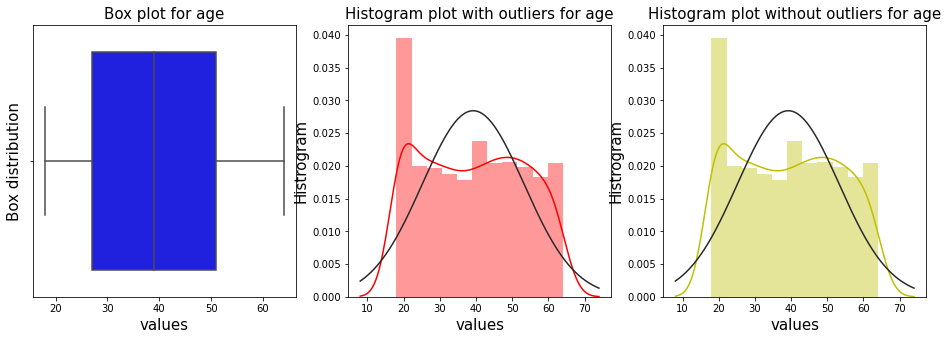

sex doesn't have any outliers


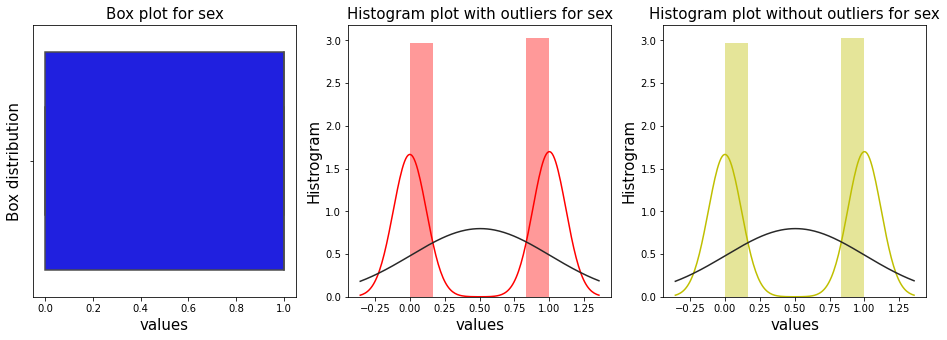

Total number of outliers in bmi is 9
Percentage of outliers in bmi data is 0.67


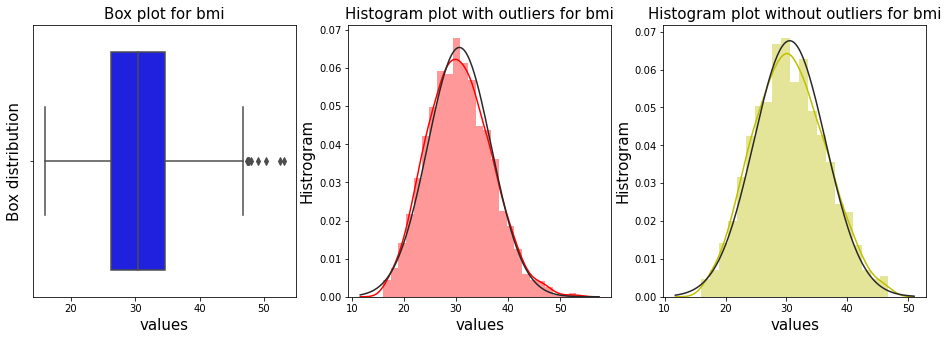

Total number of outliers in charges in INR is 139
Percentage of outliers in charges in INR data is 10.4


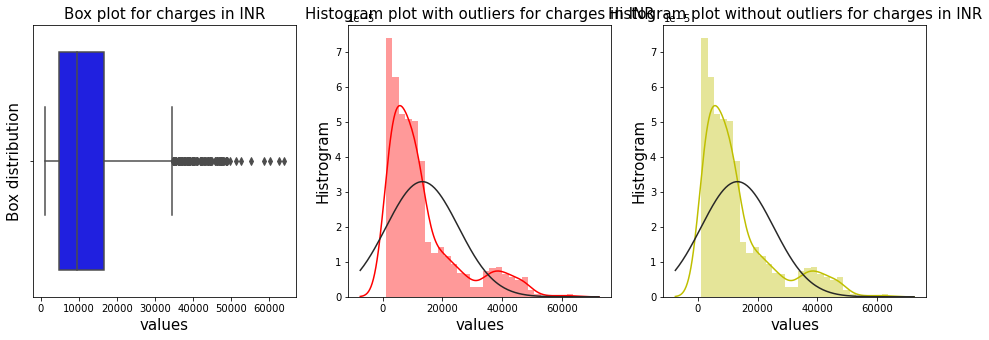

children doesn't have any outliers


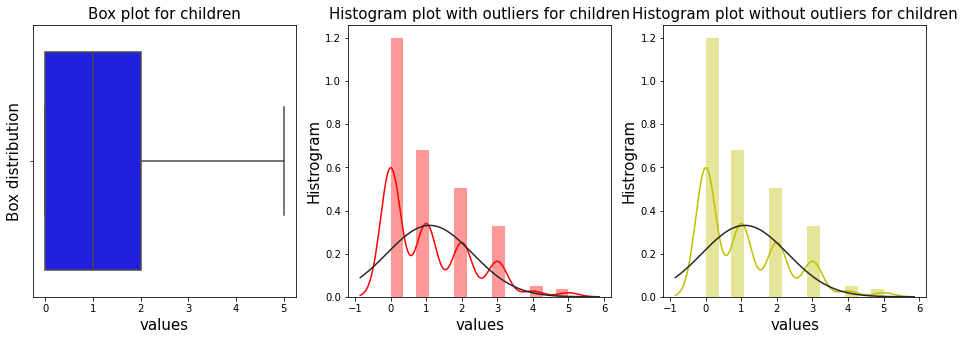

region doesn't have any outliers


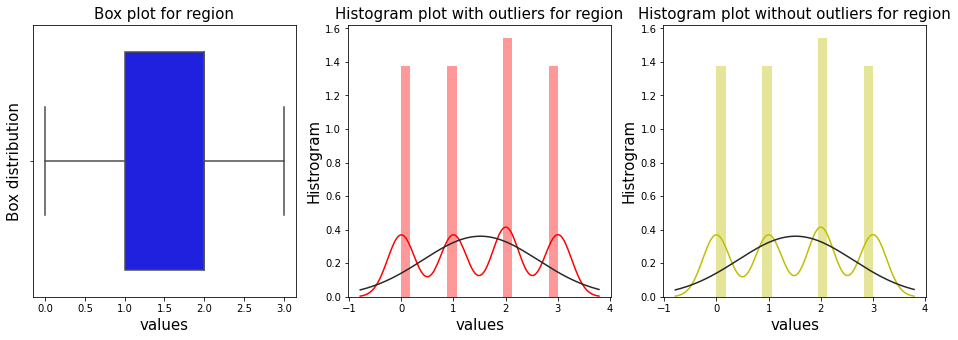

In [65]:
for col in df_full.columns:
    if col != 'smoker':
        odt_plots(df_full, col)


In [66]:
#Finding out the correlation with the target (correlation matrix)
def corr_variables(data, target):
    ind_var = data.drop([target], axis=1).columns
    corr_res =[]
    for col in ind_var:
        corr_res.append(data[target].corr(data[col]))
    res_df = pd.DataFrame([ind_var, corr_res], index=['variable','correlation']).T.sort_values('correlation', ascending = False)
    
    return res_df

In [67]:
corr_variables(df_full, 'charges in INR')

,variable,correlation
4,smoker,0.787234
0,age,0.298308
2,bmi,0.190713
3,children,0.067389
1,sex,0.058044
5,region,-0.006547


<AxesSubplot:>

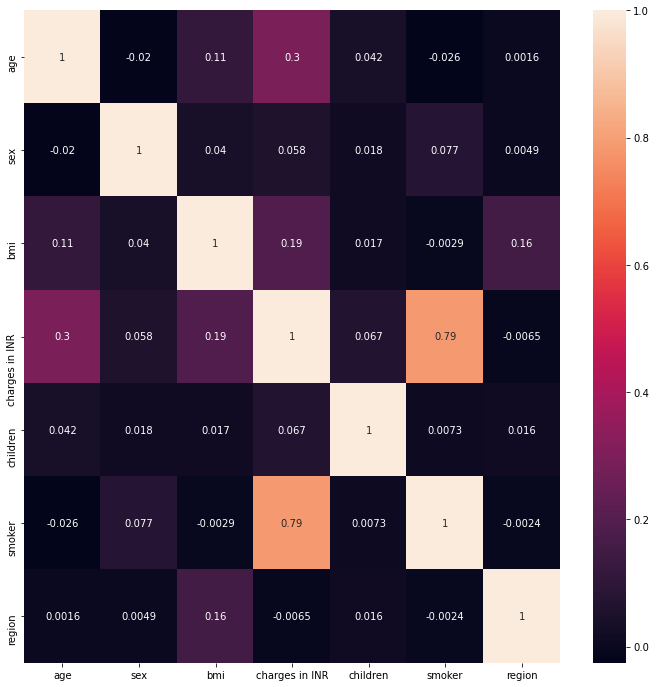

In [68]:
# Multicolinearity check (with heat map)
corr = df_full.corr()
fig = plt.subplots(figsize=(12,12))
sns.heatmap(corr, annot=True)

In [69]:
def vif_colinearity(data, target):
    ind_var = data.drop([target], axis=1)
    vif = pd.DataFrame()
    vif['vif factor'] = [variance_inflation_factor(ind_var.values,i) for i in range(ind_var.shape[1])]
    vif['variable'] = ind_var.columns
    
    return vif.sort_values('vif factor', ascending=False)

In [70]:
vif_colinearity(df_full, 'charges in INR') #Why VIF of BMI is higher than the age?

,vif factor,variable
2,10.546135,bmi
0,7.664999,age
5,2.924915,region
1,1.998268,sex
3,1.804995,children
4,1.256418,smoker


In [77]:
# As the above variables has have multicolinearity, we will apply PCA
def apply_pca(x):
    col = []
    n_comp = len(x.columns)
    
    #applying standard scalar before PCA
    x = StandardScaler().fit_transform(x)
    
    #Applying PCA in for floop
    for i in range(1,n_comp+1):
        pca = PCA(n_components=i)
        p_comp = pca.fit_transform(x)
        evr = np.cumsum(pca.explained_variance_ratio_)
        n_components = i
        if evr[i-1]>0.9:
            break
    
    print("The explained variance ratio is: ", evr)
    
    #creating data frame
    for j in range(1,n_components+1):
        col.append('pc'+str(j))
        
    result = pd.DataFrame(data = p_comp, columns=col)
    return result

In [78]:
pca_df = apply_pca(df_full.drop('charges in INR', axis=1))

The explained variance ratio is:  [0.2007775  0.38215532 0.55181012 0.71273557 0.86660598 1.        ]


In [79]:
pca_df = pca_df.join(df_full[['charges in INR']], how='left')

In [80]:
vif_colinearity(pca_df, 'charges in INR')

,vif factor,variable
3,1.0,pc4
4,1.0,pc5
0,1.0,pc1
1,1.0,pc2
2,1.0,pc3
5,1.0,pc6


In [81]:
def train_n_test_split(data, target, test_size=0.3):
    x=data.drop(target, axis=1)
    y=df_full[[target]]
    
    return train_test_split(x,y, test_size=test_size,random_state=50)

In [82]:
def build_model(model_name, estimator, data, target):
    x_train, x_test, y_train, y_test = train_n_test_split(data, target)
    estimator.fit(x_train, y_train)
    y_pred = estimator.predict(x_test)
    rmsc = np.sqrt(mean_squared_error(y_test, y_pred))
    r2score = r2_score(y_test, y_pred)
    
    temp = [model_name, rmsc, r2score]
    return temp

In [83]:
build_model('Linear regression', LinearRegression(), pca_df, 'charges in INR')

['Linear regression', 5768.820630007993, 0.7781965418837367]

In [84]:
def multiple_models(data, target):
    
    #column names in empty data frame
    col_names = ['Model name', 'rmsc', 'r2score']
    
    #Creating a empty data frame
    resultdf = pd.DataFrame(columns=col_names)
    
    resultdf.loc[len(resultdf)] = build_model('Linear regression', LinearRegression(), data, target)
    
    resultdf.loc[len(resultdf)] = build_model('Lasso', Lasso(), data, target)
    
    resultdf.loc[len(resultdf)] = build_model('Ridge', Ridge(), data, target)
    
    resultdf.loc[len(resultdf)] = build_model('Decision tree', DecisionTreeRegressor(), data, target)
    
    resultdf.loc[len(resultdf)] = build_model('KNN', KNeighborsRegressor(), data, target)
    
    resultdf.loc[len(resultdf)] = build_model('SVM regressor', SVR(), data, target)
    
    resultdf.loc[len(resultdf)] = build_model('randon forests', RandomForestRegressor(), data, target)
    
    resultdf.loc[len(resultdf)] = build_model('Ada boost', AdaBoostRegressor(), data, target)
    
    resultdf.loc[len(resultdf)] = build_model('Gboost', GradientBoostingRegressor(), data, target)
    
    resultdf.loc[len(resultdf)] = build_model('xGboost', XGBRegressor(), data, target)
    
    return resultdf
    
    

In [85]:
multiple_models(pca_df, 'charges in INR')

,Model name,rmsc,r2score
0,Linear regression,5768.820630,0.778197
1,Lasso,5769.148952,0.778171
2,Ridge,5769.800615,0.778121
3,Decision tree,6963.267523,0.676838
4,KNN,5062.660156,0.829175
5,SVM regressor,12951.009952,-0.117896
6,randon forests,4668.791912,0.854721
7,Ada boost,7917.601499,0.582187
8,Gboost,4773.941508,0.848103
9,xGboost,5345.561400,0.809550


In [61]:
#Cross validation score
def cv_score(x,y,fold=10):
    
    #defining cross validation score
    score_lr = cross_val_score(LinearRegression(),x,y,cv=fold)
    score_lasso = cross_val_score(Lasso(),x,y,cv=fold)
    score_ridge = cross_val_score(Ridge(),x,y,cv=fold)
    score_DT = cross_val_score(DecisionTreeRegressor(),x,y,cv=fold)
    score_KNN = cross_val_score(KNeighborsRegressor(),x,y,cv=fold)
    score_svm = cross_val_score(SVR(),x,y,cv=fold)
    score_RF = cross_val_score(RandomForestRegressor(),x,y,cv=fold)
    score_ADR = cross_val_score(AdaBoostRegressor(),x,y,cv=fold)
    score_GBR = cross_val_score(GradientBoostingRegressor(),x,y,cv=fold)
    score_xGBR = cross_val_score(XGBRegressor(),x,y,cv=fold)
    
    model_names = ['Linear Regression', 'Lasso regression', 'Ridge', 'Decision tree', 'kNeighbors', 'SVM', 'Random forests', 'Ada boost', 'Gradient boost', 'xGBoost']
    scores = [score_lr, score_lasso, score_ridge, score_DT, score_KNN, score_svm, score_RF, score_ADR, score_GBR, score_xGBR]
    
    result = []
    
    for i in range(0,len(model_names)):
        score_mean = np.mean(scores[i])
        score_std = np.std(scores[i])
        n_names = model_names[i]
        temp = [n_names, score_mean, score_std]
        result.append(temp)
    
    result_df = pd.DataFrame(data=result, columns=['model_names', 'average score', 'standard deviation'])
    
    return result_df
    

In [62]:
#cv_score(pca_df.drop('charges in INR', axis=1), pca_df[['charges in INR']], 10)

,model_names,average score,standard deviation
0,Linear Regression,0.743865,0.042849
1,Lasso regression,0.743867,0.042830
2,Ridge,0.743872,0.042777
3,Decision tree,0.654824,0.073952
4,kNeighbors,0.769729,0.031829
5,SVM,-0.098631,0.030144
6,Random forests,0.797603,0.049197
7,Ada boost,0.577156,0.043673
8,Gradient boost,0.801061,0.047568
9,xGBoost,0.791033,0.059556


In [63]:
#Hyper parameter tuning using grid search CV
def tuning_models(x,y,fold=10):
    params_las = {'alpha':[1e-15, 1e-13, 1e-11, 1e-9, 1e-7, 1e-5, 0.0001,0.001,0.01, 0.1, 0, 1]}
    params_rd = {'alpha':[1e-15, 1e-13, 1e-11, 1e-9, 1e-7, 1e-5, 0.0001,0.001,0.01, 0.1, 0, 1]}
    params_rf = {'n_estimators':[5,6,7,8,9,10,20,30,40,50,60,70,80,90,100]}
    params_knn = {'n_neighbors':[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25]}
    params_adb = {'learning_rate':[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0], 'n_estimators':[10,20,30,40,50,60,70,80,90,100]}
    params_gb = {'learning_rate':[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0], 'n_estimators':[10,20,30,40,50,60,70,80,90,100]}
    params_xgb = {'learning_rate':[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0], 'n_estimators':[10,20,30,40,50,60,70,80,90,100],
                 'gamma': [10,20,30,40,50,60,70,80,90,100]}
    
    
    tune_lasso = GridSearchCV(Lasso(), params_las, cv=fold)
    tune_ridge = GridSearchCV(Ridge(), params_rd, cv=fold)
    tune_rf = GridSearchCV(RandomForestRegressor(), params_rf, cv=fold)
    tune_knn = GridSearchCV(KNeighborsRegressor(), params_knn, cv=fold)
    tune_adb = GridSearchCV(AdaBoostRegressor(), params_adb, cv=fold)
    tune_gb = GridSearchCV(GradientBoostingRegressor(), params_gb, cv=fold)
    tune_xgb = GridSearchCV(XGBRegressor(), params_xgb, cv=fold)
    
    tune_lasso.fit(x,y)
    tune_ridge.fit(x,y)
    tune_rf.fit(x,y)
    tune_knn.fit(x,y)
    tune_adb.fit(x,y)
    tune_gb.fit(x,y)
    tune_xgb.fit(x,y)
    
    tune = [tune_lasso, tune_ridge, tune_rf, tune_knn, tune_adb, tune_gb, tune_xgb]
    model_names = ['Lasso regression', 'Ridge', 'Random forests', 'KNeighbors', 'Ada boost', 'Gradient boost', 'xGBoost']
    
    
    for i in range(0,len(tune)):
        print('Model', model_names[i])
        print('Best parameters', tune[i].best_params_ )
    

In [64]:
#tuning_models(pca_df.drop('charges in INR', axis=1), pca_df[['charges in INR']])

In [66]:
def cv_score_tuned(x,y,fold=10):
    
    #defining cross validation score
    score_lr = cross_val_score(LinearRegression(),x,y,cv=fold)
    score_lasso = cross_val_score(Lasso(alpha=1.0),x,y,cv=fold)
    score_ridge = cross_val_score(Ridge(alpha=1.0),x,y,cv=fold)
    score_DT = cross_val_score(DecisionTreeRegressor(),x,y,cv=fold)
    score_KNN = cross_val_score(KNeighborsRegressor(),x,y,cv=fold)
    score_svm = cross_val_score(SVR(),x,y,cv=fold)
    score_RF = cross_val_score(RandomForestRegressor(n_estimators=100),x,y,cv=fold)
    score_ADR = cross_val_score(AdaBoostRegressor(learning_rate=0.1, n_estimators=10),x,y,cv=fold)
    score_GBR = cross_val_score(GradientBoostingRegressor(learning_rate=0.1, n_estimators=40),x,y,cv=fold)
    score_xGBR = cross_val_score(XGBRegressor(gamma=10, learning_rate=0.1, n_estimators=40),x,y,cv=fold)
    
    model_names = ['Linear Regression', 'Lasso regression', 'Ridge', 'Decision tree', 'kNeighbors', 'SVM', 'Random forests', 'Ada boost', 'Gradient boost', 'xGBoost']
    scores = [score_lr, score_lasso, score_ridge, score_DT, score_KNN, score_svm, score_RF, score_ADR, score_GBR, score_xGBR]
    
    result = []
    
    for i in range(0,len(model_names)):
        score_mean = np.mean(scores[i])
        score_std = np.std(scores[i])
        n_names = model_names[i]
        temp = [n_names, score_mean, score_std]
        result.append(temp)
    
    result_df = pd.DataFrame(data=result, columns=['model_names', 'average score', 'standard deviation'])
    
    return result_df

In [79]:
#cv_score_tuned(pca_df.drop('charges in INR', axis=1), pca_df[['charges in INR']], 10)

<AxesSubplot:xlabel='smoker', ylabel='charges in INR'>

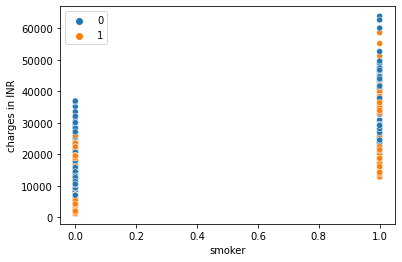

In [80]:
#applying clustering in order to see if the accuracy increases

x=df_full.drop('charges in INR', axis=1)
y=df_full[['charges in INR']]

from sklearn.cluster import KMeans

labels = KMeans(n_clusters=2, random_state=50).fit_predict(x)
sns.scatterplot(x=x['smoker'], y=y['charges in INR'], hue=labels)

In [71]:
def clusters_in_data(x,target, labels):
    columns = list(set(list(x.columns))-set(target))
    r = int(len(columns)/2)
    
    
    
    if r%2 == 0:
        r=r
    else:
        r=r+1
        
    
    f, ax = plt.subplots(r,2, figsize=(15,15))
    a=0
    for row in range(0,r):
        for col in range(0,2):
            if a != len(columns):
                ax[row][col].scatter(x[target], x[columns[a]], c=labels)
                ax[row][col].set_xlabel(target)
                ax[row][col].set_ylabel(columns[a])
                a=a+1

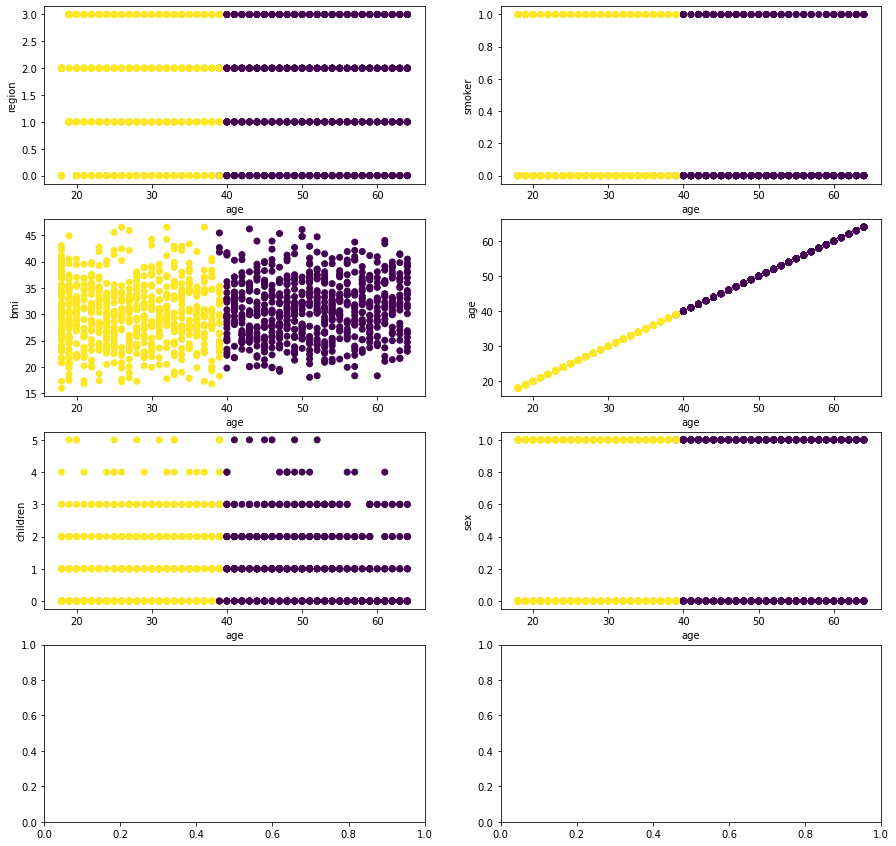

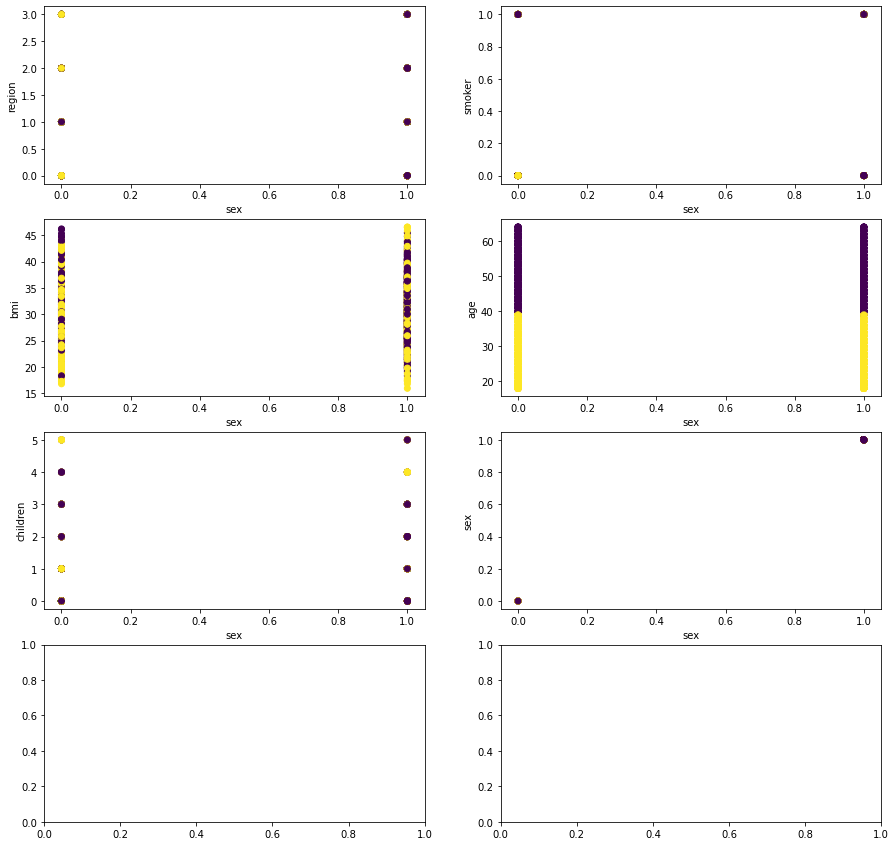

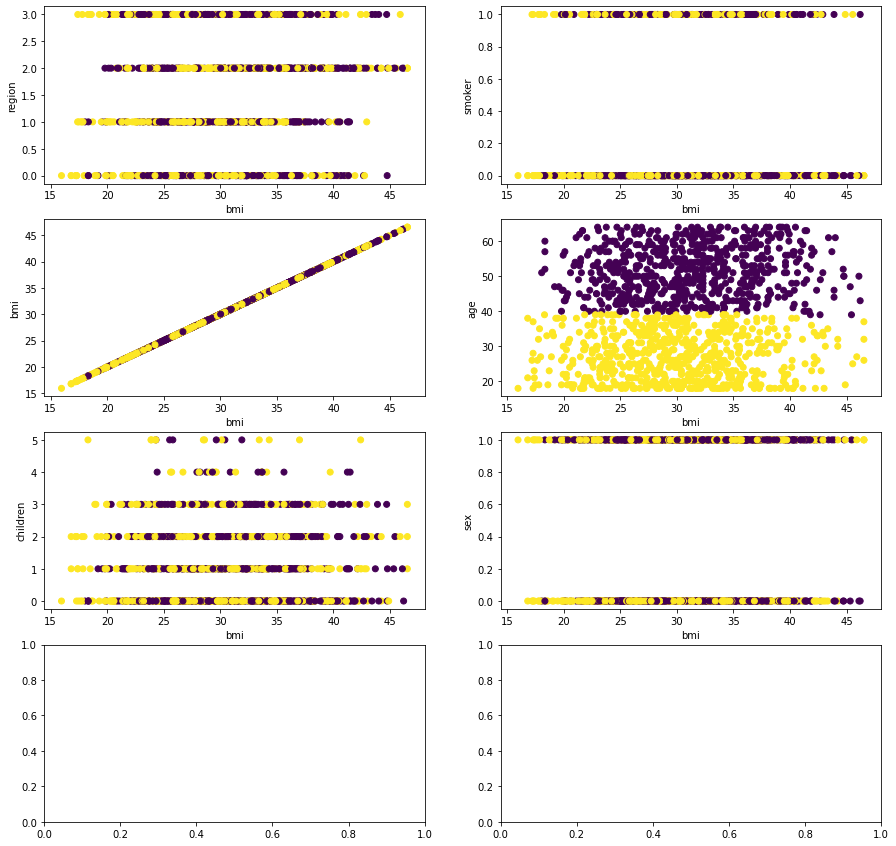

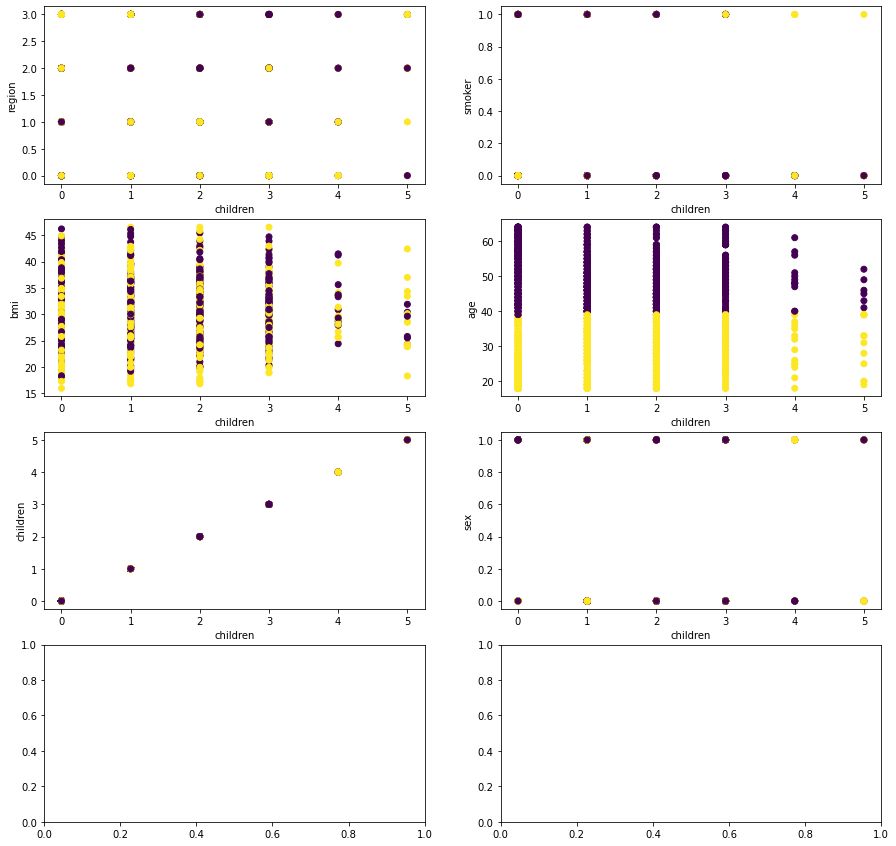

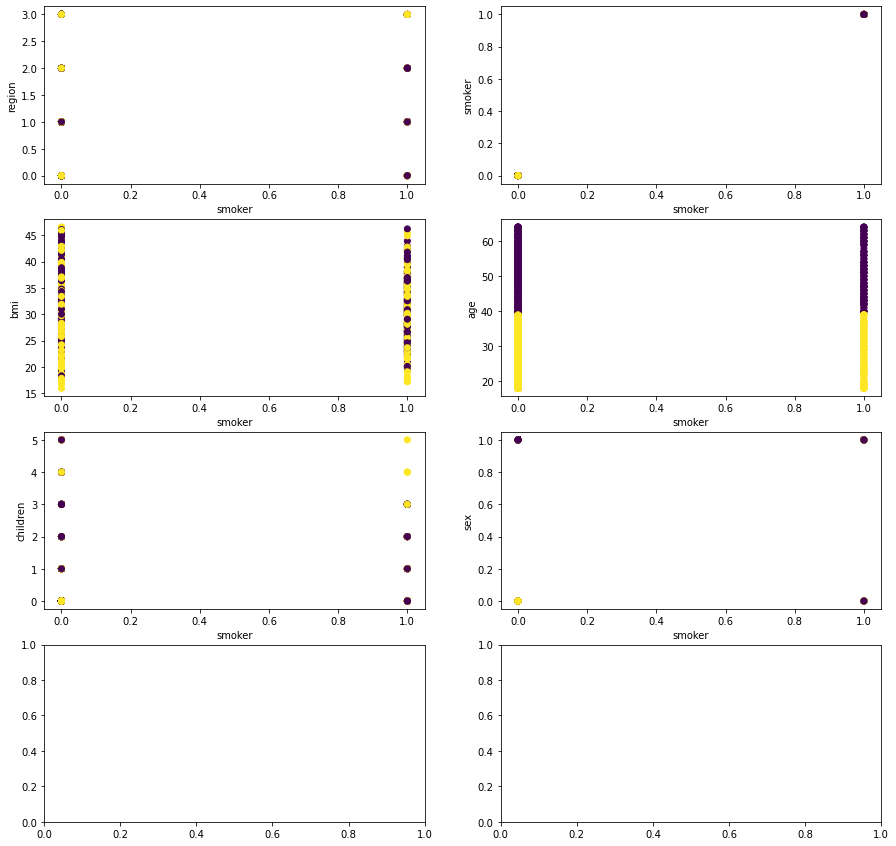

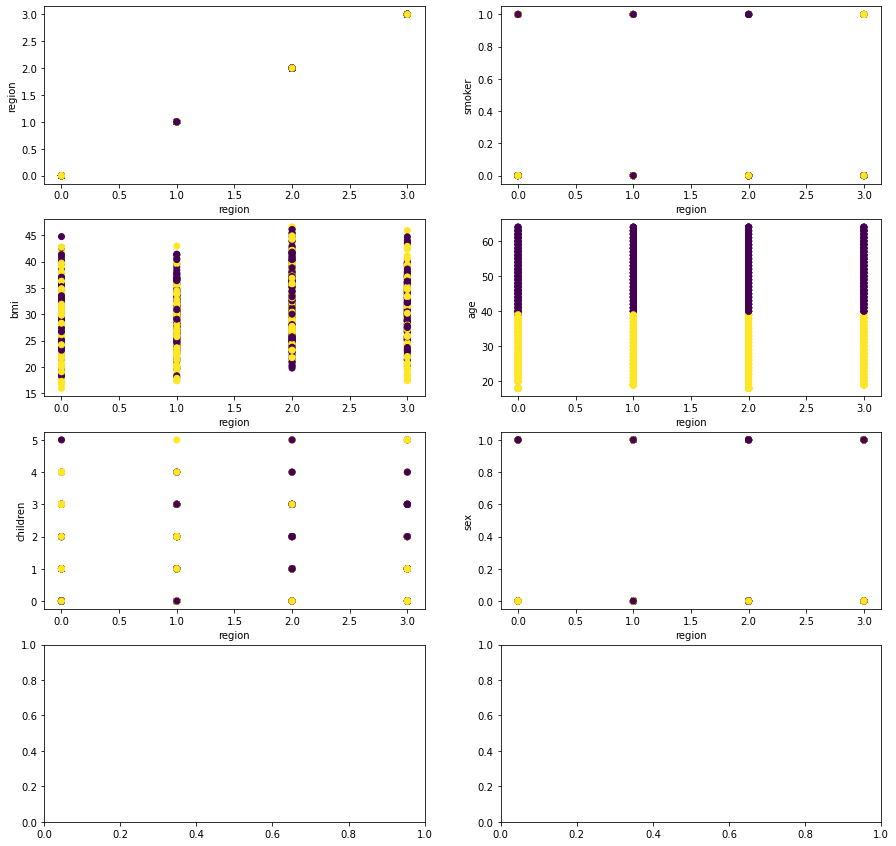

In [72]:
for col in x.columns:
    clusters_in_data(x, col, labels)

In [73]:
clustered_df = df_full.join(pd.DataFrame(labels, columns=['labels']), how='left')

In [78]:
#clustered_df

In [75]:
new_feature = clustered_df.groupby('labels')['age'].agg(['mean', 'median'])

In [76]:
clustered_df = clustered_df.merge(new_feature, on='labels', how='left')

In [77]:
cv_score_tuned(clustered_df.drop('charges in INR', axis=1), clustered_df[['charges in INR']], 10)

,model_names,average score,standard deviation
0,Linear Regression,0.743589,0.042695
1,Lasso regression,0.743600,0.042671
2,Ridge,0.743602,0.042348
3,Decision tree,0.697309,0.046708
4,kNeighbors,0.122251,0.058721
5,SVM,-0.106435,0.031260
6,Random forests,0.833072,0.048793
7,Ada boost,0.843812,0.045530
8,Gradient boost,0.859028,0.044150
9,xGBoost,0.846392,0.048904
